In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator

In [3]:
"""
 İşleme girilecek veriler ön işlemeye alınıyor ön işlemede

 1. Verinin temizlenmesi : Boş veriler, yanlış veriler ve kayıp veriler silinir ya da doldurulur.
 2. Verinn Azaltılması : Aynı sonucu veren verilerin temizlenerek depolanan verinin azaltılması işlemi.
 3. Verinin Dönüştürülmesi : Verilerin işleme alabilmek için çevrimler dizi şekillendirmesi verilerin ölçütlenmesi gibi işlemleri içerir.
 4. Veri Birleştirilmesi : Birden fazla veri yığını olduğu zamanlarda bunların birleştirilmesinde kullanılır.
"""
def preprocess(array):
    """
      dizi uygun formata çevriliyor ve veri ölçekleniyor.
    """
    array = array.astype("float32")
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

In [4]:
def normalize(array):
  array = array.astype("float32") / 255.0
  return array

In [5]:
def noise(array):
    """
      Verilen dizideki elemanlara rastgele gürültü ekleniyor.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [6]:
def display(array1, array2):
    """
     Parametre olarak girilen her diziden rastgele 10 resim gösterir.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [7]:
def random_flip(x_train,y_train):
    """
      ImageDataGenerator kullanılarak resimler rastgele olarak döndürülüyor.
    """
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
    # Veri seti uygun formata getiriliyor.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

    # Veriye belirlenen döndürme işlemleri rastgele olarak uygulanılıyor.
    datagen.fit(x_train)
    flow = datagen.flow(x_train, y_train, batch_size=9)
    
    return flow


In [8]:
def datagen_to_array(datagen):
    """
      Verilen NumpyIterator iki ayrı diziye dönüştürülüyor.
    """
    datagen.reset()
    x=np.concatenate([datagen.next()[0] for i in range(datagen.__len__())])
    y=np.concatenate([datagen.next()[1] for i in range(datagen.__len__())])
    return x,y

In [9]:
# Data set yükleniyor.
(train_data, result_train_data), (test_data, result_test_data) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [10]:
# Aynı veri büyütülüyor.
flow = random_flip(train_data,result_train_data)
flow_test = random_flip(test_data,result_test_data)

In [11]:
# Büyütüken veri diziye aktarılıyor..
x,y = datagen_to_array(flow)
z,t = datagen_to_array(flow_test)

In [12]:
# Veri ön işlemeye alınıyor..
train_data = preprocess(train_data)
test_data = preprocess(test_data)

In [13]:
# Mevcut veriye değişim yapılan veri ekleniyor.
augmentation_data = np.concatenate((train_data,x))
augmentation_data = preprocess(augmentation_data)
augmentation_test_data = np.concatenate((test_data,z))
augmentation_test_data = preprocess(augmentation_test_data)

In [19]:
augmentation_data = normalize(augmentation_data)
augmentation_test_data = normalize(augmentation_test_data)
print(augmentation_data.shape)

(120000, 28, 28, 1)


In [15]:
# Veriye gürültü ekleniyor.
noisy_train_data = noise(augmentation_data)
noisy_test_data = noise(augmentation_test_data)

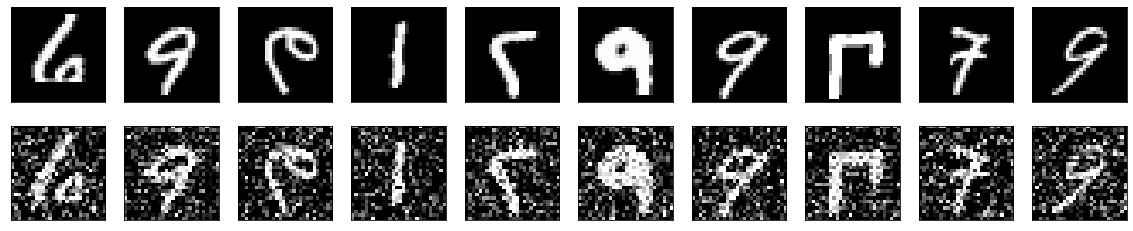

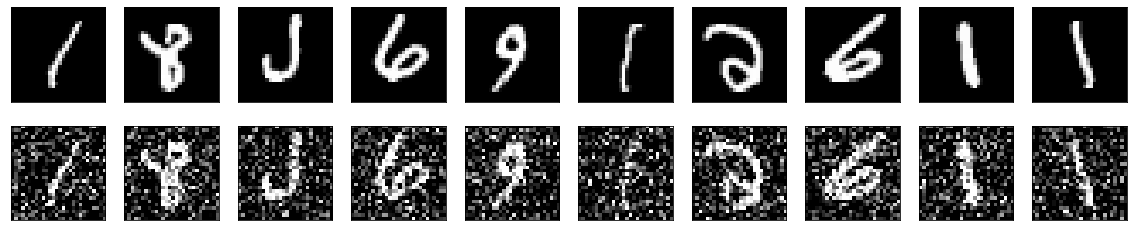

In [16]:
# Modele girmeye hazır verilen gösteriliyor.
display(augmentation_data, noisy_train_data)
display(augmentation_test_data, noisy_test_data)

In [17]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

In [18]:
resnet_model = Sequential()

for layer in autoencoder.layers:
  layer.trainable=False

resnet_model.add(autoencoder)

resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(10, activation = 'softmax'))

resnet_model.layers[0].trainable = False

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 28, 28, 1)         28353     
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 435,403
Trainable params: 407,050
Non-trainable params: 28,353
_________________________________________________________________


In [28]:
resnet_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
resnet_model.fit(x=augmentation_data,y=augmentation_data,epochs=10,validation_data=(augmentation_test_data, augmentation_test_data))

Epoch 1/10


ValueError: ignored

In [17]:
autoencoder.fit(
    x=augmentation_data,
    y=augmentation_data,
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(augmentation_test_data, augmentation_test_data),
)

Epoch 1/3
938/938 [==============================] - 280s 298ms/step - loss: 0.1015 - val_loss: 0.0699
Epoch 2/3
938/938 [==============================] - 277s 295ms/step - loss: 0.0691 - val_loss: 0.0675
Epoch 3/3
938/938 [==============================] - 290s 309ms/step - loss: 0.0675 - val_loss: 0.0665


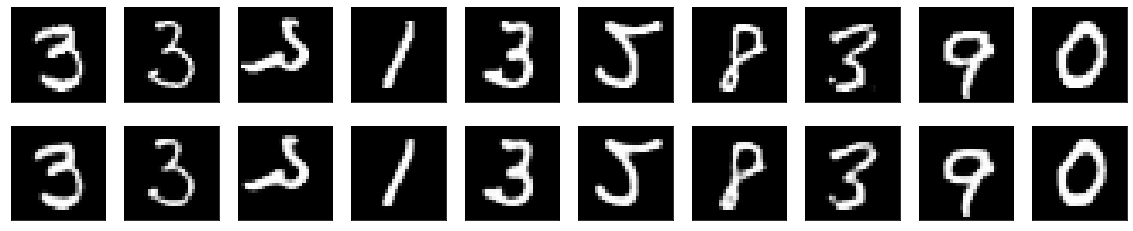

In [30]:
predictions = autoencoder.predict(augmentation_test_data)
display(augmentation_test_data, predictions)